#### For subject B15

In [18]:
import numpy as np, imageio, re, glob

data_dir = "./yaleB_data/CroppedYalePNG/yaleB15_P00A"
file_list = sorted(glob.glob(data_dir + "*.png"))
images = []
light_dirs = []

for filename in file_list:
    
    name = filename.split("/")[-1]
    if "Ambient" in name:
        continue
        
    # Parsing azimuth (A) and elevation (E) from filename (e.g. A+035E+65)
    m = re.search(r"A([+-]\d+)E([+-]\d+)", name)
    
    if not m: 
        continue
    az, el = int(m.group(1)), int(m.group(2))
    
    # Converting degrees to radians
    az_rad = np.deg2rad(az)
    el_rad = np.deg2rad(el)

    
    # Computing light direction (camera-centered coordinate frame)
    Lx =  np.cos(el_rad) * np.sin(az_rad)
    Ly =  np.sin(el_rad)
    Lz =  np.cos(el_rad) * np.cos(az_rad)
    
    light_dirs.append((Lx, Ly, Lz))
    
    # Loading image and normalize intensity
    img = imageio.imread(filename).astype(np.float64) / 255.0
    images.append(img)

images = np.stack(images, axis=0)  
light_dirs = np.array(light_dirs)  


/tmp/ipykernel_1219634/3318407632.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename).astype(np.float64) / 255.0


#### Calculating normals

In [19]:
# Reshaping image stack for linear solve: (N_images, H*W)
N_img, H, W = images.shape
I_stack = images.reshape(N_img, -1)  # each column is intensities for one pixel
L = light_dirs  # shape (N_images, 3)

# Solving for (rho * N) at each pixel via least-squares (pseudo-inverse)
# x = (L^T L)^{-1} L^T I  => shape (3, H*W)
L_pinv = np.linalg.pinv(L)
X = L_pinv.dot(I_stack)    # shape (3, H*W) = [ρN_x; ρN_y; ρN_z]

# Compute albedo and normals
rho = np.linalg.norm(X, axis=0)                # scalar albedo per pixel
nonzero = rho > 1e-8
N_stack = np.zeros_like(X)
N_stack[:, nonzero] = X[:, nonzero] / rho[nonzero]  # normalize to unit normals

# Reshape normal components to image grids
Nx = N_stack[0,:].reshape(H, W)
Ny = N_stack[1,:].reshape(H, W)
Nz = N_stack[2,:].reshape(H, W)
albedo = rho.reshape(H, W)

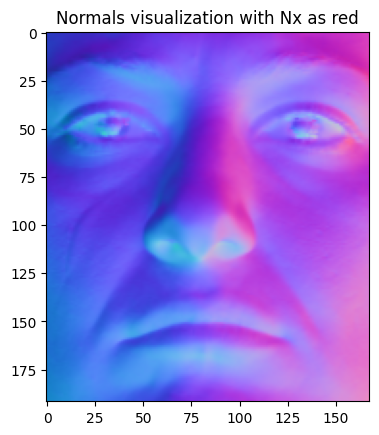

In [20]:
import matplotlib.pyplot as plt

normals_vis = np.stack([-Nx, -Ny, Nz], axis=-1)
normals_vis = (normals_vis + 1) / 2
plt.imshow(normals_vis)
plt.title("Normals visualization with Nx as red")
plt.show()


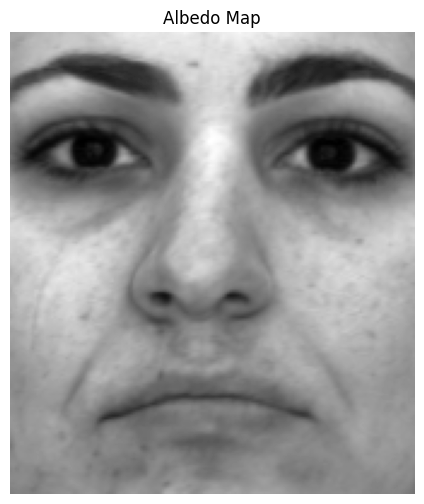

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))
plt.title("Albedo Map")
plt.imshow(albedo, cmap='gray') 
plt.axis('off')
plt.show()


#### Computing depth

In [22]:
# Compute gradients p, q
p = -Nx / (Nz + 1e-8)
q = -Ny / (Nz + 1e-8)

# Fourier integration (Frankot-Chellappa)
# Setup frequency grids
fx = np.fft.fftfreq(W) * 2*np.pi
fy = np.fft.fftfreq(H) * 2*np.pi
FX, FY = np.meshgrid(fx, fy)

P = np.fft.fft2(p)
Q = np.fft.fft2(q)

# Avoid zero frequency division
denom = (FX**2 + FY**2)
denom[0,0] = 1.0


# Compute Fourier-domain height
Z_freq = -(1j*FX * P + 1j*FY * Q) / denom
Z_freq[0,0] = 0  # set the DC component (offset) to zero
# Inverse FFT to get depth
Z = np.real(np.fft.ifft2(Z_freq))

# Create grid of (X,Y) pixel coordinates
X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)
# Stack into (H*W, 3) vertex array
vertices = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

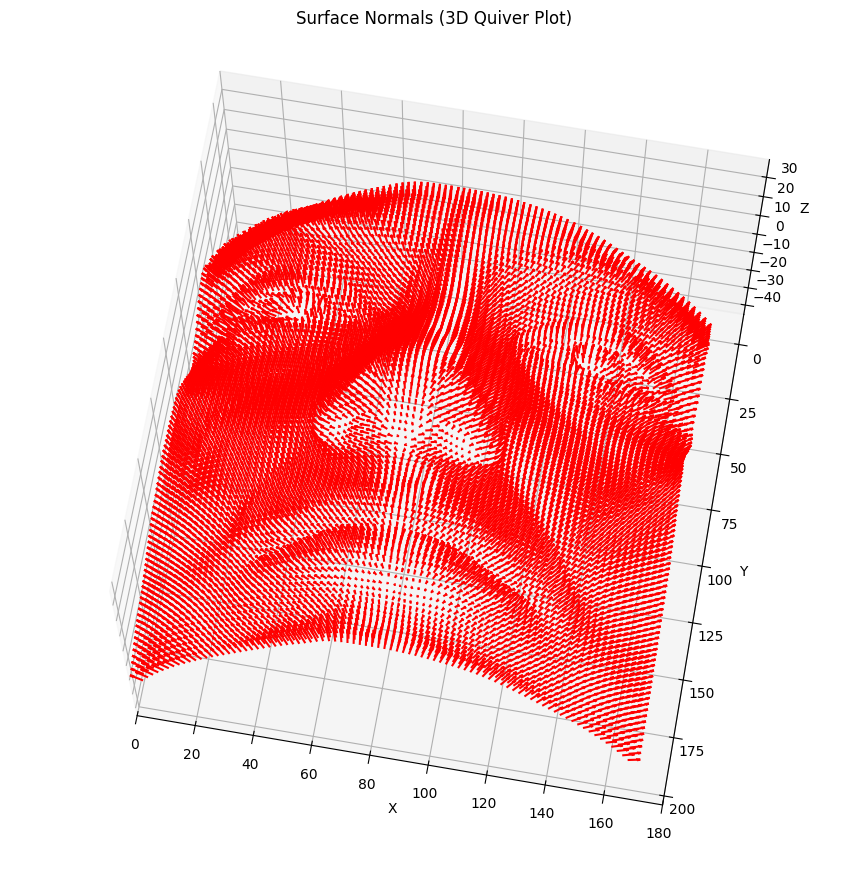

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create grid of (X,Y) pixel coordinates
X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)
# --- Downsample for clarity ---
step = 2 
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = Z[::step, ::step]
Nx_plot = Nx[::step, ::step]
Ny_plot = Ny[::step, ::step]
Nz_plot = Nz[::step, ::step]

Z_plot = -Z_plot  

Nz_plot = Nz_plot


# --- Create 3D quiver plot ---
fig = plt.figure(figsize=(12, 9))


ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot, Y_plot, Z_plot, -Nx_plot, -Ny_plot, Nz_plot, length=5.0, normalize=True, color='r')
ax.view_init(elev=70, azim=100)  
ax.set_xlim(180,0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
plt.tight_layout()
plt.show()


In [24]:
faces = []
for i in range(H-1):
    for j in range(W-1):
        idx = i*W + j
        # vertices of the quad: [idx, idx+1, idx+W, idx+W+1]
        faces.append([idx,     idx+1,   idx+W    ])  # first triangle
        faces.append([idx+1,   idx+W+1, idx+W    ])  # second triangle
faces = np.array(faces, dtype=np.int32)


import open3d as o3d


mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices) 
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()  # for nicer shading
o3d.visualization.draw_geometries([mesh])

o3d.io.write_triangle_mesh("./generated_mesh/B15_MESH.ply", mesh)

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)


True

In [25]:
albedo_flat= albedo.reshape(-1)
albedo_norm = albedo_flat / albedo_flat.max()

# any value darker than thresh becomes true black
thresh = 0.29
albedo_norm[albedo_norm < thresh] = 0.0

colors = np.stack([albedo_norm]*3, axis=1)
mesh.vertex_colors = o3d.utility.Vector3dVector(colors)

o3d.io.write_triangle_mesh("./generated_mesh/B15_MESH_clr.ply", mesh)

True

#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_B15_MESH.ply.gif)


#### Colored
![Mesh Animation_2.gif](./generated_mesh/ImageToStl.com_B15_MESH_clr.ply.gif)

#### Another subject

In [26]:
import numpy as np, imageio, re, glob

data_dir = "./yaleB_data/CroppedYalePNG/yaleB08_P00A"
file_list = sorted(glob.glob(data_dir + "*.png"))
images = []
light_dirs = []

for filename in file_list:
    
    name = filename.split("/")[-1]
    if "Ambient" in name:
        continue
        
    # Parsing azimuth (A) and elevation (E) from filename (e.g. A+035E+65)
    m = re.search(r"A([+-]\d+)E([+-]\d+)", name)
    
    if not m: 
        continue
    az, el = int(m.group(1)), int(m.group(2))
    
    # Converting degrees to radians
    az_rad = np.deg2rad(az)
    el_rad = np.deg2rad(el)

    
    # Computing light direction (camera-centered coordinate frame)
    Lx =  np.cos(el_rad) * np.sin(az_rad)
    Ly =  np.sin(el_rad)
    Lz =  np.cos(el_rad) * np.cos(az_rad)
    
    light_dirs.append((Lx, Ly, Lz))
    
    # Loading image and normalize intensity
    img = imageio.imread(filename).astype(np.float64) / 255.0
    images.append(img)

images = np.stack(images, axis=0)  
light_dirs = np.array(light_dirs)  


/tmp/ipykernel_1219634/759246484.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename).astype(np.float64) / 255.0


In [27]:
# Reshaping image stack for linear solve: (N_images, H*W)
N_img, H, W = images.shape
I_stack = images.reshape(N_img, -1)  # each column is intensities for one pixel
L = light_dirs  # shape (N_images, 3)

# Solving for (rho * N) at each pixel via least-squares (pseudo-inverse)
# x = (L^T L)^{-1} L^T I  => shape (3, H*W)
L_pinv = np.linalg.pinv(L)
X = L_pinv.dot(I_stack)    # shape (3, H*W) = [ρN_x; ρN_y; ρN_z]

# Compute albedo and normals
rho = np.linalg.norm(X, axis=0)                # scalar albedo per pixel
nonzero = rho > 1e-8
N_stack = np.zeros_like(X)
N_stack[:, nonzero] = X[:, nonzero] / rho[nonzero]  # normalize to unit normals

# Reshape normal components to image grids
Nx = N_stack[0,:].reshape(H, W)
Ny = N_stack[1,:].reshape(H, W)
Nz = N_stack[2,:].reshape(H, W)
albedo = rho.reshape(H, W)

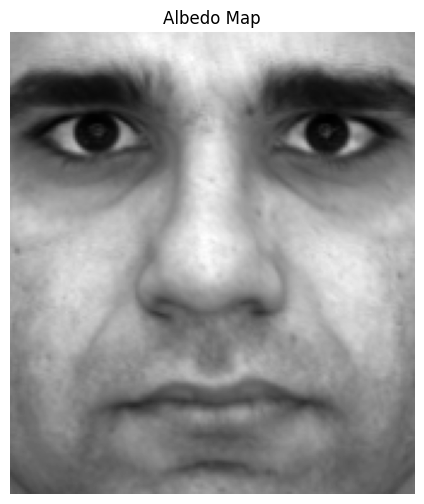

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))
plt.title("Albedo Map")
plt.imshow(albedo, cmap='gray')  
plt.axis('off')
plt.show()


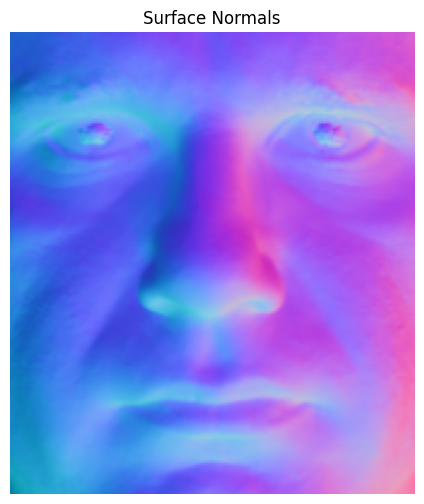

In [29]:

normals_vis = np.stack([-Nx, -Ny, Nz], axis=-1)  
normals_vis = (normals_vis + 1.0) / 2.0        

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.title("Surface Normals")
plt.imshow(normals_vis)
plt.axis('off')
plt.show()


In [30]:
# Compute gradients p, q
p = -Nx / (Nz + 1e-8)
q = -Ny / (Nz + 1e-8)

# Fourier integration (Frankot-Chellappa)
# Setup frequency grids
fx = np.fft.fftfreq(W) * 2*np.pi
fy = np.fft.fftfreq(H) * 2*np.pi
FX, FY = np.meshgrid(fx, fy)

P = np.fft.fft2(p)
Q = np.fft.fft2(q)

# Avoid zero frequency division
denom = (FX**2 + FY**2)
denom[0,0] = 1.0


# Compute Fourier-domain height 
Z_freq = -(1j*FX * P + 1j*FY * Q) / denom
Z_freq[0,0] = 0  # set the DC component (offset) to zero
# Inverse FFT to get depth
Z = np.real(np.fft.ifft2(Z_freq))

# Create grid of (X,Y) pixel coordinates
X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)
# Stack into (H*W, 3) vertex array
vertices = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

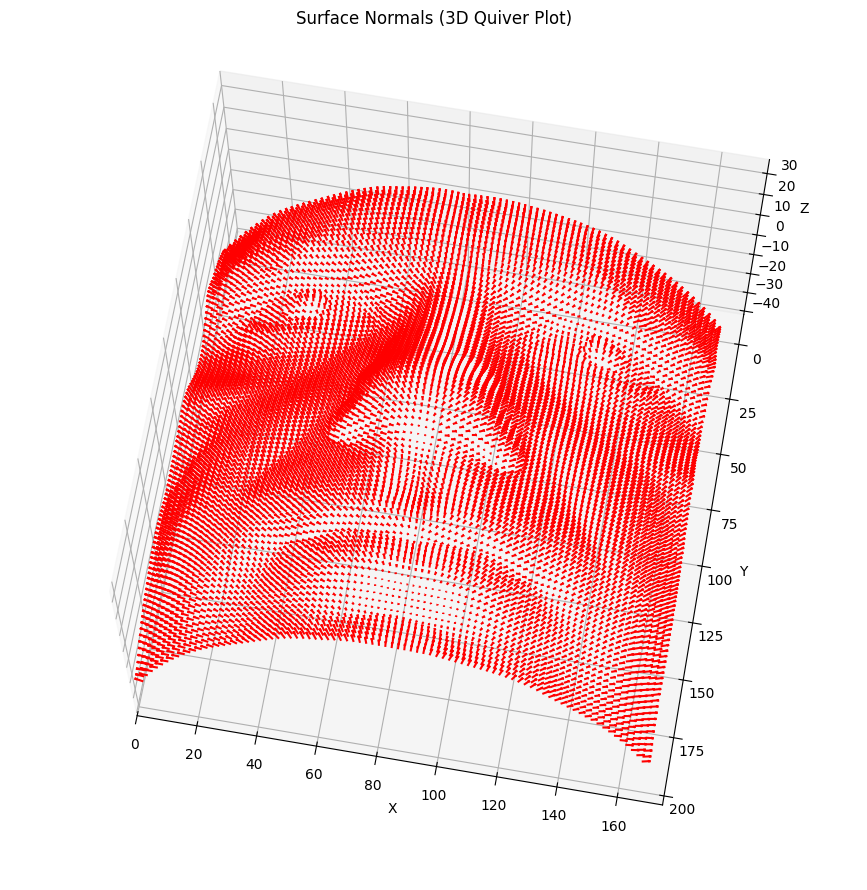

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create grid of (X,Y) pixel coordinates
X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)

step = 2 
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = Z[::step, ::step]
Nx_plot = Nx[::step, ::step]
Ny_plot = Ny[::step, ::step]
Nz_plot = Nz[::step, ::step]

Z_plot =- Z_plot  



# --- Create 3D quiver plot ---
fig = plt.figure(figsize=(12, 9))


ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot, Y_plot, Z_plot, -Nx_plot, -Ny_plot, Nz_plot, length=3.0, normalize=True, color='r')
ax.view_init(elev=70, azim=100)  
ax.set_xlim(175,0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
plt.tight_layout()
plt.show()


In [32]:
faces = []
for i in range(H-1):
    for j in range(W-1):
        idx = i*W + j
        # vertices of the quad: [idx, idx+1, idx+W, idx+W+1]
        faces.append([idx,     idx+1,   idx+W    ])  # first triangle
        faces.append([idx+1,   idx+W+1, idx+W    ])  # second triangle
faces = np.array(faces, dtype=np.int32)


import open3d as o3d

# Create an Open3D TriangleMesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices) 
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()  # for nicer shading
o3d.visualization.draw_geometries([mesh])

o3d.io.write_triangle_mesh("./generated_mesh/B09_MESH.ply", mesh)

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)


True

In [33]:
albedo_flat= albedo.reshape(-1)
albedo_norm = albedo_flat / albedo_flat.max()

# any value darker than thresh becomes true black
thresh = 0.29
albedo_norm[albedo_norm < thresh] = 0.0

colors = np.stack([albedo_norm]*3, axis=1)
mesh.vertex_colors = o3d.utility.Vector3dVector(colors)

o3d.io.write_triangle_mesh("./generated_mesh/B09_MESH_clr.ply", mesh)

True

#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_B09_MESH.ply.gif)


#### Mesh Color
![Mesh Animation2.gif](./generated_mesh/ImageToStl.com_B09_MESH_clr+(1).ply.gif)